# Resources
- https://arxiv.org/pdf/2309.02427: Cognitive Architectures for Language Agents
- https://arxiv.org/pdf/2401.08500: Code Generation with AlphaCodium: From Prompt Engineering to Flow Engineering

# Reflective agent
- Be an agent that has an ability of self-critique where one task is for generating content and the other is for revising and providing feedback/recommendations to improve generated content
- It acts like two systems in `Thinking, Fast and Slow`. System 1 (reactive, instinctive) and system 2 (methodical and reflective)

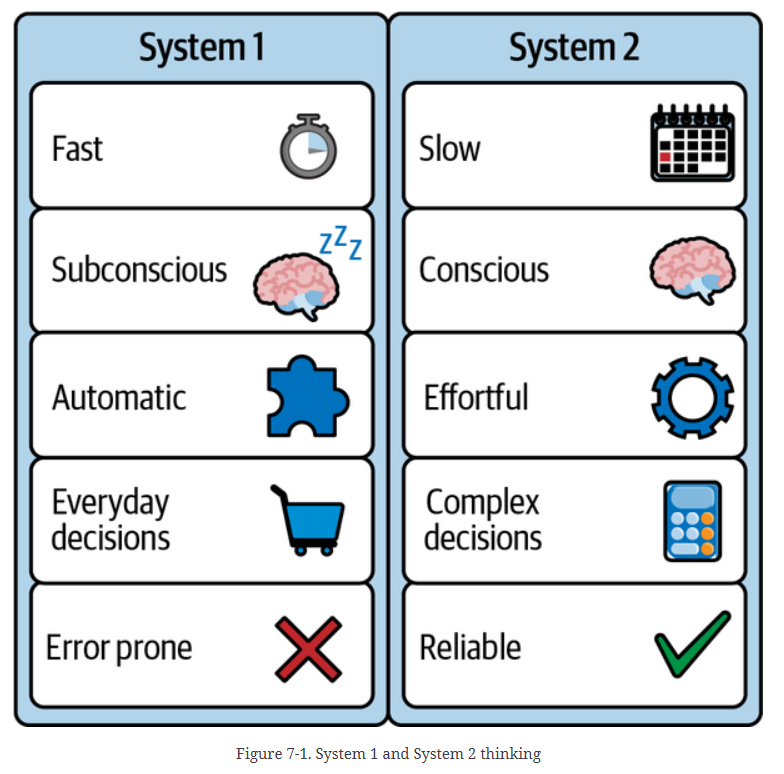


In [12]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

model = ChatOpenAI()

In [13]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    """You are an essay assistant tasked with writing excellent 3-paragraph 
        essays."""
    "Generate the best essay possible for the user's request."
    """If the user provides critique, respond with a revised version of your 
        previous attempts."""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

In [14]:
reflection_prompt = SystemMessage(
    """You are a teacher grading an essay submission. Generate critique and 
        recommendations for the user's submission."""
    """Provide detailed recommendations, including requests for length, depth, 
        style, etc."""
)

def reflect(state: State) -> State:
    # Invert the messages to get the LLM to reflect on its own output
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # First message is the original user request. 
    # We hold it the same for all nodes
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content) 
            for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=answer.content)]}

In [17]:
def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)

builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue, ['reflect', END])
builder.add_edge("reflect", "generate")

graph = builder.compile()

View graph

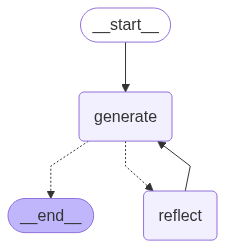

In [16]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")

In [18]:
for event in graph.stream({
    "messages": [("user", "Write an essay about the importance of AI in modern society")],    
}):
    # Retrieve and print the chatbot node responses
    for value in event.values():
        print("Agent:", value["messages"], end="\n")

Agent: [AIMessage(content='Artificial Intelligence (AI) has become an indispensable part of modern society, revolutionizing various industries and reshaping the way we live and work. One of the key importance of AI lies in its ability to enhance efficiency and productivity in businesses. AI technologies such as machine learning and natural language processing have enabled automation of tasks, data analysis, and decision-making processes, leading to cost savings and improved operational performance. From customer service chatbots to predictive analytics in healthcare, AI has proven to be a powerful tool in streamlining operations and driving innovation.\n\nMoreover, the impact of AI is not limited to the business sector but also extends to various aspects of daily life. In healthcare, AI-powered medical devices and algorithms are assisting healthcare professionals in diagnosing diseases, personalizing treatment plans, and even predicting patient outcomes. AI is also playing a crucial ro